In [14]:
#importing libraries

# For Data Processing & ML Models
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix as cm
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img
from PIL import Image, ImageEnhance

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
# from tqdm import tqdm
import os
import random

In [15]:
# Data exploring

data_dir = '/content/drive/MyDrive/hdata/'

In [16]:
all_paths = []
all_labels = []

for label in os.listdir(data_dir):
    for image in os.listdir(data_dir+label):
        all_paths.append(data_dir+label+'/'+image)
        all_labels.append(label)

all_paths, all_labels = shuffle(all_paths, all_labels)
# ['normal','notnormal','violence']

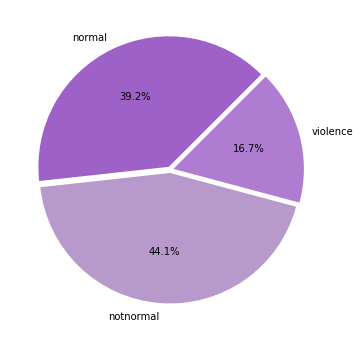

In [17]:
plt.figure(figsize=(14,6))
colors = ["#9D61C8", "#B799CB", "#ae7cd1"]
plt.pie([len([x for x in all_labels if x=='normal']),
         len([x for x in all_labels if x=='notnormal']),
         len([x for x in all_labels if x=='violence'])],
        labels=['normal','notnormal','violence'],
        colors=colors, autopct='%.1f%%', explode=(0.025,0.025,0.025),
        startangle=45);

In [18]:
#Splitting dataset
# 80% - train data 
# 20% - test data or validation data

x_train, x_val, y_train, y_val = train_test_split(all_paths, all_labels, test_size=0.2, random_state=42)

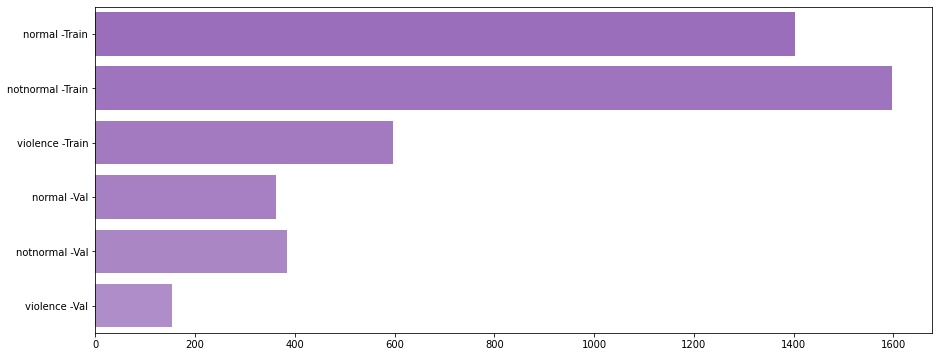

In [19]:
# ['dandelion','daisy', 'sunflower', 'tulip', 'rose'] 
plt.figure(figsize=(15, 6))
sns.barplot(x=[len([x for x in y_train if x=='normal']),
               len([x for x in y_train if x=='notnormal']),
               len([x for x in y_train if x=='violence']),
               len([x for x in y_val if x=='normal']),
               len([x for x in y_val if x=='notnormal']),
               len([x for x in y_val if x=='violence'])],
            y=['normal -Train',
               'notnormal -Train',
               'violence -Train',
               'normal -Val',
               'notnormal -Val',
               'violence -Val',
],
           palette = sns.light_palette("#9D61C8", reverse = True, n_colors = int(19 * 1.2)))
plt.show()

In [20]:
#Data augmentation

# Random brightness: 60%- 140%
# Random contrast: 60%- 140%
# Random saturation: 60%- 140%
# horizontal flip

IMAGE_SIZE = 200

def augment_image(image):
    if random.uniform(0,1)>0.5:
        image = np.fliplr(image)
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.6,1.4))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.6,1.4))
    image = ImageEnhance.Color(image).enhance(random.uniform(0.6,1.4))
    return image

def open_images(paths, augment=True):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = np.array(image)
        if augment:
            image = augment_image(image)
        image = np.array(image)/255.0
        images.append(image)
    return np.array(images)

In [21]:
#Data Generation

unique_labels = os.listdir(data_dir)

#labels encoding 

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def data_gen(paths, labels, batch_size=12, epochs=3, augment=True):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths, augment=augment)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

In [22]:
#Model

base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), weights='imagenet', include_top=False)
for layer in base_model.layers:
    layer.trainable = False
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

In [23]:
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(len(unique_labels), activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 18432)             0         
                                                                 
 dropout_3 (Dropout)         (None, 18432)             0         
                                                                 
 dense_3 (Dense)             (None, 512)               9437696   
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dropout_5 (Dropout)         (None, 256)              

In [24]:
model.compile(optimizer=Adam(learning_rate=0.000175),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

In [ ]:
# Model Training

batch_size = 32
steps = int(len(x_train)/batch_size)
epochs = 20
history = model.fit(data_gen(x_train, y_train, batch_size=batch_size, epochs=epochs, augment=True),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/20
  9/112 [=>............................] - ETA: 31:40 - loss: 1.1948 - sparse_categorical_accuracy: 0.4653

In [ ]:
# Accuracy vs loss graph

plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
# Model evalution
from tqdm import tqdm
batch_size=32
steps = int(len(x_val)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(data_gen(x_val, y_val, batch_size=batch_size, epochs=1, augment=False), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

In [ ]:
print(classification_report(y_true, y_pred))